In [ ]:
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from searchTest.toyEnvironment import check_outpt


In [ ]:
path_train = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/train/'
path_validate = '/home/hendrik/Documents/master_project/LokalData/metaworld/small/val/'
train_data = TorchDatasetMWToy(path=path_train, device='cpu')
val_data = TorchDatasetMWToy(path=path_validate, device='cpu')
print(train_data.data.shape)
print(train_data.label.shape)

In [ ]:
train_data.data.size(0)

In [ ]:
import stable_baselines3

In [ ]:
env = gym.make("CartPole-v1")
env.metadata

In [ ]:
class my_env():
    def __init__(self, train_data):
        #obs = step, data, action, current_env
        self.observation_space = gym.spaces.box.Box(np.array([0, -2,-2,-2,-2, 0,0,0,0.,0]), np.array([6, 2,2,2,2, 1,1,1,1.,train_data.data.size(0)]), (10,), float)
        #next state (4)
        self.action_space = gym.spaces.box.Box(np.array([0,0,0,0]), np.array([1,1,1,1]), (4,), float)
        self.metadata = {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
        self.steps = 0
        self.current_env = -1
        self.data = train_data.data
        self.label = train_data.label
        self.traj = None
    def reset(self):
        self.traj = None
        self.current_env = (self.current_env + 1)%len(self.data)
        self.steps = 0
        last_action = torch.zeros(4, dtype=float, device=self.data.device)
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)
        data = self.data[self.current_env, 0]
        #label = self.label[self.current_env,0]
        state = torch.cat((step.view(1), data, last_action, current_env.view(1)), dim=0)
        return state

    def step(self, action):
        if type(action) is np.ndarray:
            action = torch.tensor(action, device=self.data.device)
        if self.traj is None:
            self.traj = action.reshape(1,-1)
        else:
            self.traj = torch.cat((self.traj, action.reshape(1,-1)), dim=0)



        self.steps += 1
        step = torch.tensor(self.steps, device=self.data.device)
        current_env = torch.tensor(self.current_env, device=self.data.device)

        #label = self.label[self.current_env, self.current_step]
        data = self.data[self.current_env, 0]

        state = torch.cat((step.view(1), data, action.reshape(-1), current_env.view(1)))
        if self.steps >= self.label.size(1):
            tol_neg = -0.55*torch.ones([self.traj.size(-1)])
            tol_pos = 0.7*torch.ones([self.traj.size(-1)])
            reward = int(check_outpt(self.label[self.current_env].unsqueeze(0), self.traj.unsqueeze(0), tol_neg=tol_neg, tol_pos=tol_pos))
            return (state, reward, True, {})
        else:
            return (state, 0., False, {})

    def close(self):
        pass
    
    def render(self, mode):
        pass

class toy_exper_model(OnPolicyAlgorithm):
    def __init__(
            self,
            policy: Union[str, Type[ActorCriticPolicy]] = 'MlpPolicy',
            env: Union[GymEnv, str] = None,
            learning_rate: Union[float, Schedule] = 3e-4,
            n_steps: int = 2048,
            batch_size: int = 64,
            n_epochs: int = 10,
            gamma: float = 0.99,
            gae_lambda: float = 0.95,
            clip_range: Union[float, Schedule] = 0.2,
            clip_range_vf: Union[None, float, Schedule] = None,
            normalize_advantage: bool = True,
            ent_coef: float = 0.0,
            vf_coef: float = 0.5,
            max_grad_norm: float = 0.5,
            use_sde: bool = False,
            sde_sample_freq: int = -1,
            target_kl: Optional[float] = None,
            tensorboard_log: Optional[str] = None,
            create_eval_env: bool = False,
            policy_kwargs: Optional[Dict[str, Any]] = None,
            verbose: int = 0,
            seed: Optional[int] = None,
            device: Union[th.device, str] = "auto",
            _init_setup_model: bool = True,
            train_data = None
        ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            create_eval_env=create_eval_env,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )
        self.data = train_data.data
        self.label = train_data.label


    def predict(self, obs, state=None, episode_start=None, deterministic=False):
        step = int(obs.reshape(-1)[0])
        env = int(obs.reshape(-1)[-1])
        return self.label[env, step].reshape(1, -1), self.label[env, step].reshape(1, -1)


In [ ]:
env = my_env(train_data=train_data)
val_env = my_env(train_data=val_data)
my_expert = toy_exper_model(train_data=train_data, env=env)

In [ ]:

def sample_expert_transitions():
    expert = my_expert

    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(env)]),
        rollout.make_sample_until(min_timesteps=None, min_episodes=10000),
    )
    return rollout.flatten_trajectories(rollouts)

In [ ]:
# @author Simon Stepputtis <sstepput@asu.edu>, Interactive Robotics Lab, Arizona State University

from pickle import NONE
from urllib.parse import non_hierarchical
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from hashids import Hashids
import cv2
import os
from MetaWorld.searchTest.toyEnvironment import make_sliding_tol



class TBoardGraphsTorch():
    def __init__(self, logname= None, data_path = None):
        if logname is not None:
            self.__hashids           = Hashids()
            #self.logdir              = "Data/TBoardLog/" + logname + "/"
            self.logdir              = os.path.join(data_path, "gboard/" + logname + "/")
            print(f'log dir: {self.logdir + "train/"}')
            self.__tboard_train      = tf.summary.create_file_writer(self.logdir + "train/")
            self.__tboard_validation = tf.summary.create_file_writer(self.logdir + "validate/")
            #self.voice               = Voice(path=data_path)
        self.fig, self.ax = plt.subplots(3,3)

    def startDebugger(self):
        tf.summary.trace_on(graph=True, profiler=True)
    
    def stopDebugger(self):
        with self.__tboard_validation.as_default():
            tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=self.logdir)

    def finishFigure(self, fig):
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data
    
    def addTrainScalar(self, name, value, stepid):
        with self.__tboard_train.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def addValidationScalar(self, name, value, stepid):
        with self.__tboard_validation.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def torch2tf(self, inpt):
        if inpt is not None:
            return tf.convert_to_tensor(inpt.detach().cpu().numpy())
        else:
            return inpt

    def plotTrajectory(self, y_true, y_pred, dt_true, dt_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_dt_true = self.torch2tf(dt_true)
        tf_dt_pred = self.torch2tf(dt_pred)

        fig, ax = plt.subplots(3,3)
        fig.set_size_inches(9, 9)

        tf_dt_true = 1.0/tf_dt_true.numpy()
        tf_dt_pred = 1.0/tf_dt_pred.numpy()[0]

        max_trj_len = tf_y_true.shape[0]
        for sp in range(7):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()
            ax[idx,idy].plot(range(max_trj_len), tf_y_pred[:,sp], alpha=0.5, color='midnightblue')
            ax[idx,idy].plot(range(max_trj_len), tf_y_true[:,sp], alpha=0.5, color='forestgreen')
            # ax[idx,idy].plot([dt_pred, dt_pred], [-0.1, 1.1], alpha=0.5, linestyle=":", color="midnightblue")
            # ax[idx,idy].plot([dt_true, dt_true], [-0.1, 1.1], alpha=0.5, linestyle=":", color="forestgreen")
            # ax[idx,idy].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Trajectory", data=result, step=stepid)

    def idToText(self, id):
        names = ["", "ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        return names[id]

    def plotImageRegions(self, image, image_dict, stepid):
        # Visualization of the results of a detection.
        num_detected = len([v for v in image_dict["detection_scores"][0] if v > 0.5]) 
        image_np     = image.numpy()       
        for i in range(num_detected):
            ymin, xmin, ymax, xmax = image_dict['detection_boxes'][0][i,:]
            pt1 = (int(xmin*image_np.shape[1]), int(ymin*image_np.shape[0]))
            pt2 = (int(xmax*image_np.shape[1]), int(ymax*image_np.shape[0]))
            image_np = cv2.rectangle(image_np, pt1, pt2, (255, 0, 0), 2)
            image_np = cv2.putText(image_np, self.idToText(image_dict['detection_classes'][0][i]) + " {:.1f}%".format(image_dict["detection_scores"][0][i] * 100), pt1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

        fig = plt.figure()
        plt.imshow(image_np)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Image", data=result, step=stepid)

    def plotAttention(self, attention_weights, image_dict, language, stepid):
        tf_attention_weights = self.torch2tf(attention_weights)
        tf_language = self.torch2tf(language)

        tf_attention_weights = tf_attention_weights.numpy()
        classes           = image_dict["detection_classes"][0][:len(tf_attention_weights)].numpy().astype(dtype=np.int32)
        classes           = [self.idToText(i) for i in classes]
        x                 = np.arange(len(tf_attention_weights))
        
        fig, ax = plt.subplots()
        plt.bar(x, tf_attention_weights)
        plt.xticks(x, classes)
        ax.set_ylim([0, 1])
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)
    
    def plotClassAccuracy(self, gt_class, pred_class, pred_class_std, language, stepid):
        labels     = ["ysr", "rsr", "gsr", "bsr", "psr", "ylr", "rlr", "glr", "blr", "plr", "yss", "rss", "gss", "bss", "pss", "yls", "rls", "gls", "bls", "pls"]
        tf_gt_class = self.torch2tf(gt_class)
        tf_pred_class = self.torch2tf(pred_class)
        tf_language = self.torch2tf(language)

        
        
        tf_gt_class   = tf_gt_class.numpy()
        tf_pred_class = tf_pred_class.numpy()
        x          = np.arange(len(tf_gt_class))
        width      = 0.35
        
        fig, ax = plt.subplots()
        #rects1 = ax.bar(x - width/2, gt_class, width, label='GT', color="forestgreen")
        #rects2 = ax.bar(x + width/2, pred_class, width, yerr=pred_class_std, label='Pred', color="midnightblue")
        ax.set_xticks(x)
        # ax.set_xticklabels(labels)
        plt.text(0.01, 0.95, self.voice.tokensToSentence(tf_language.numpy().tolist()), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Attention", data=result, step=stepid)

    def plotDeltaT(self, y_true, y_pred, stepid):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)

        gt = tf_y_true.numpy()
        pd = tf_y_pred.numpy()[:,0]
        jdata = np.stack((gt,pd), axis=1)
        svals = jdata[np.argsort(jdata[:,0]),:]
        x     = np.arange(svals.shape[0])
        width = 0.35
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, svals[:,0], width, label='GT', color="forestgreen")
        rects2 = ax.bar(x + width/2, svals[:,1], width, label='Pred', color="midnightblue")
        ax.set_xticks(x)

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("DeltaT", data=result, step=stepid)

    def plotWeights(self, gt_w, pred_w, stepid):
        tf_gt_w = self.torch2tf(gt_w)
        tf_pred_w = self.torch2tf(pred_w)

        fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,sharex=True)
        # fig.set_size_inches(4, 10)

        combined_weights = np.concatenate((tf_gt_w.numpy(), tf_pred_w.numpy()), axis=0).T

        ax1.imshow(combined_weights[:,:7], cmap="RdBu")
        ax2.imshow(combined_weights[:,7:], cmap="RdBu")

        result = np.expand_dims(self.finishFigure(fig), 0)
        plt.close()
        with self.__tboard_validation.as_default():
            tf.summary.image("Weights", data=result, step=stepid)

    def interpolateTrajectory(self, trj, target):
        tf_trj = self.torch2tf(trj)
        tf_target = self.torch2tf(target)

        current_length = tf_trj.shape[0]
        dimensions     = tf_trj.shape[1]
        result         = np.zeros((tf_target, dimensions), dtype=np.float32)
    
        for i in range(dimensions):
            result[:,i] = np.interp(np.linspace(0.0, 1.0, num=tf_target), np.linspace(0.0, 1.0, num=current_length), trj[:,i])
        
        return result

    def plotDMPTrajectory(self, y_true, y_pred, y_pred_std = None, phase= None, \
        dt= None, p_dt= None, stepid= None, name = "Trajectory", save = False, \
            name_plot = None, path=None, tol_neg = None, tol_pos=None, inpt = None, opt_gen_trj=None, window = 0):
        tf_y_true = self.torch2tf(y_true)
        tf_y_pred = self.torch2tf(y_pred)
        tf_phase = self.torch2tf(phase)
        tf_inpt = self.torch2tf(inpt)
        if p_dt is not None:
            tf_dt = self.torch2tf(dt)
            tf_p_dt = self.torch2tf(p_dt)
        if opt_gen_trj is not None:
            tf_opt_gen_trj = self.torch2tf(opt_gen_trj)
            tf_opt_gen_trj = tf_opt_gen_trj.numpy()

        tf_y_true      = tf_y_true.numpy()
        tf_y_pred      = tf_y_pred.numpy()
        tf_inpt        = tf_inpt.numpy()
        if tf_phase is not None:
            tf_phase       = tf_phase.numpy()

        if p_dt is not None:
            tf_dt          = tf_dt.numpy() * 350.0
            tf_p_dt        = tf_p_dt.numpy()
        trj_len      = tf_y_true.shape[0]
        
        #fig, ax = plt.subplots(3,3)
        fig, ax = self.fig, self.ax
        #fig.set_size_inches(9, 9)
        if window > 0:
            neg_inpt, pos_inpt, tf_y_true = make_sliding_tol(label=y_true.unsqueeze(0), neg_tol=tol_neg, pos_tol=tol_pos, window=window)
            tf_y_true = tf_y_true[0].detach().cpu().numpy()
            trj_len      = tf_y_true.shape[0]
            tf_y_pred = y_pred[int(window/2):-(int(window/2) + 1)].detach().cpu().numpy()
            neg_inpt = neg_inpt.detach().cpu().numpy()
            pos_inpt = pos_inpt.detach().cpu().numpy()
            if opt_gen_trj is not None:
                tf_opt_gen_trj = opt_gen_trj[int(window/2):-(int(window/2) + 1)].detach().cpu().numpy()
        else:
            neg_inpt = tf_y_true + tol_neg[None,:].cpu().numpy()
            pos_inpt = tf_y_true + tol_pos[None,:].cpu().numpy()
        for sp in range(len(tf_y_true[0])):
            idx = sp // 3
            idy = sp  % 3
            ax[idx,idy].clear()

            # GT Trajectory:
            if tol_neg is not None:

                ax[idx,idy].plot(range(tf_y_pred.shape[0]), neg_inpt[:,sp], alpha=0.75, color='orangered')
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), pos_inpt[:,sp], alpha=0.75, color='orangered')
            ax[idx,idy].plot(range(trj_len), tf_y_true[:,sp],   alpha=1.0, color='forestgreen')            
            ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], alpha=0.75, color='mediumslateblue')
            if opt_gen_trj is not None:
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), tf_opt_gen_trj[:,sp], alpha=0.75, color='lightseagreen')
                diff_vec = tf_opt_gen_trj - tf_y_pred
                ax[idx,idy].plot(range(tf_y_pred.shape[0]), diff_vec[:,sp], alpha=0.75, color='pink')

            #ax[idx,idy].errorbar(range(tf_y_pred.shape[0]), tf_y_pred[:,sp], xerr=None, yerr=None, alpha=0.25, fmt='none', color='mediumslateblue')
            #ax[idx,idy].set_ylim([-0.1, 1.1])
            if p_dt is not None:
                ax[idx,idy].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')

        if inpt is not None:
            ax[-1,-1].clear()
            ax[-1,-1].plot(range(inpt.shape[-1]), tf_inpt,   alpha=1.0, color='forestgreen')     
        
        if tf_phase is not None:
            ax[2,2].clear()
            ax[2,2].plot(range(tf_y_pred.shape[0]), tf_phase, color='orange')
        if p_dt is not None:
            ax[2,2].plot([tf_dt, tf_dt], [0.0,1.0], linestyle=":", color='forestgreen')
            ax[2,2].plot([tf_p_dt*350.0, tf_p_dt*350.0], [0.0,1.0], linestyle=":", color='mediumslateblue')
            ax[2,2].set_ylim([-0.1, 1.1])

        result = np.expand_dims(self.finishFigure(fig), 0)
        if save:
            if not os.path.exists(path):
                os.makedirs(path)
            plt.savefig(path + name_plot + '.png')
        #fig.clear()
        #plt.close()
        if not save:
            with self.__tboard_validation.as_default():
                tf.summary.image(name, data=result, step=stepid)

In [ ]:
class TBoardGraphsTorch():
    def __init__(self, logname= None, data_path = None):
        if logname is not None:
            self.__hashids           = Hashids()
            #self.logdir              = "Data/TBoardLog/" + logname + "/"
            self.logdir              = os.path.join(data_path, "gboard/" + logname + "/")
            print(f'log dir: {self.logdir + "train/"}')
            self.__tboard_train      = tf.summary.create_file_writer(self.logdir + "train/")
            self.__tboard_validation = tf.summary.create_file_writer(self.logdir + "validate/")
        self.fig, self.ax = plt.subplots(3,3)

    def startDebugger(self):
        tf.summary.trace_on(graph=True, profiler=True)
    
    def stopDebugger(self):
        with self.__tboard_validation.as_default():
            tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=self.logdir)

    def finishFigure(self, fig):
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data
    
    def addTrainScalar(self, name, value, stepid):
        with self.__tboard_train.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def addValidationScalar(self, name, value, stepid):
        with self.__tboard_validation.as_default():
            tfvalue = self.torch2tf(value)
            tf.summary.scalar(name, tfvalue, step=stepid)

    def torch2tf(self, inpt):
        if inpt is not None:
            return tf.convert_to_tensor(inpt.detach().cpu().numpy())
        else:
            return inpt
def Voice(path):
    pass 

In [ ]:
from hashids import Hashids
import tensorflow as tf
import matplotlib.pyplot as plt
tboard = TBoardGraphsTorch(logname='asd', data_path='/home/hendrik/Documents/master_project/LokalData/test/')

In [ ]:
from imitation.policies import *

policy = ActorCriticPolicy(observation_space=env.observation_space, action_space=env.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[200, 200], vf=[200, 200])])

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(policy)

In [ ]:
transitions = sample_expert_transitions()

In [ ]:
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    policy=policy,
    device='cpu'
)
#bc_trainer.train(n_epochs=300)

log dir: /home/hendrik/Documents/master_project/LokalData/test/gboard/asd/train/


AttributeError: 'TBoardGraphsTorch' object has no attribute 'plotDMPTrajectory'

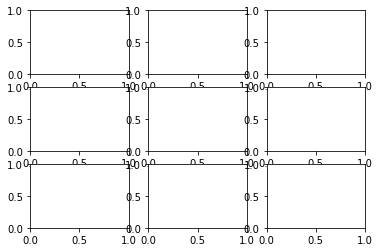

In [31]:
tboard = TBoardGraphsTorch(logname='asd', data_path='/home/hendrik/Documents/master_project/LokalData/test/')
for i in range(100):
    rew = []
    for j in range(1000):
        obs = val_env.reset()
        done = False
        while not done:
            action, _ = bc_trainer.policy.predict(obs)
            obs, reward, done, _ = val_env.step(action=action)
        target_trj = val_env.label[val_env.current_env].unsqueeze(0)
        gen_trj = val_env.traj.unsqueeze(0)
        inpt = val_env.data[val_env.current_env].unsqueeze(0)
        tol_neg = -0.55*torch.ones([val_env.traj.size(-1)])
        tol_pos = 0.7*torch.ones([val_env.traj.size(-1)])
        tboard.plotDMPTrajectory(target_trj, gen_trj, torch.zeros_like(gen_trj),
                                    None, None, None, stepid=i, save=False, name_plot='imitation baseline', path='',\
                                        tol_neg=tol_neg, tol_pos=tol_pos, inpt = inpt, name='imitation baseline', opt_gen_trj = None, window=None)
        rew.append(reward)
    reward = torch.tensor(rew).type(torch.float).mean()
    print(reward)
    tboard.addValidationScalar('success rate', reward.detach(), stepid=i)
    #bc_trainer.train(n_epochs=5)


In [ ]:
reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward before training: {reward}")

print("Training a policy using Behavior Cloning")
bc_trainer.train(n_epochs=10)

reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward after training: {reward}")

In [ ]:
reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward before training: {reward}")

print("Training a policy using Behavior Cloning")
bc_trainer.train(n_epochs=1)

reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward after training: {reward}")

In [ ]:
reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward before training: {reward}")

print("Training a policy using Behavior Cloning")
bc_trainer.train(n_epochs=1)

reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=3, render=True)
print(f"Reward after training: {reward}")

In [ ]:
model = PPO("MlpPolicy", env, verbose=1)
type(model)

In [ ]:
#env = gym.make("CartPole-v1")
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10)

In [ ]:
for i in range(10):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(action)
    print(obs)
    #env.render()
    if done:
      obs = env.reset()

env.close()

In [ ]:
obs